# Предсказание сердечно-сосудистых заболеваний

Импорт библиотек, скачивание датасета: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [72]:
!pip install kagglehub

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from IPython.display import display
import shutil
import os


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

if not os.path.exists('dataset'):
    path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")
    work_dir = os.getcwd()

    os.rename(path, 'dataset')

    print("Path to dataset files:", path)
    print("Path to work directory", work_dir)

## EDA

### Признаки:
**age**: возраст (дни) int \
**height**: рост (см) int  \
**weight**: вес (кг) float  \
**gender**: пол (бинарный признак) int  \
**ap_hi**: верхнее артериальное давление int  \
**ap_lo**: нижнее артериальное давление int  \
**cholesterol**: холестерин (1: в норме, 2: выше нормы, 3: значительно выше нормы) int  \
**gluc**: глюкоза (1: в норме, 2: выше нормы, 3: значительно выше нормы) int  \
**smoke**: Курение (бинарный признак) int  \
**alco**: Употребление алкоголя (бинарный признак) int  \
**active**: Физическая активность (бинарный признак) int  \
**cardio**: Наличие или отсутствие сердечно-сосудистых заболеваний (целевая переменная, бинарная) int  

столбец id бесполезен для обучения модели

In [74]:
df = pd.read_csv('.\dataset\cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [75]:
df.shape

(70000, 13)

В данных нет дисбаланса классов

In [76]:
df['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

В данных нет дубликатов

In [77]:
df.duplicated().sum().sum()

np.int64(0)

В данных нет пропусков, все признаки целочисленные/дробные

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


признаки ap_hi и ap_lo имеют выбросы

In [79]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


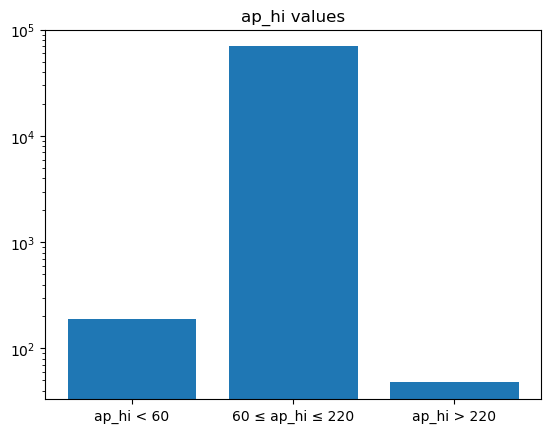

In [80]:
x = ['ap_hi < 60', '60 ≤ ap_hi ≤ 220', 'ap_hi > 220']
y = [sum(df['ap_hi'] < 60), sum((df['ap_hi'] <= 220) & (df['ap_hi'] >= 60)), sum(df['ap_hi'] > 220)]


plt.bar(x, y, log=True, tick_label=x);
plt.title('ap_hi values');

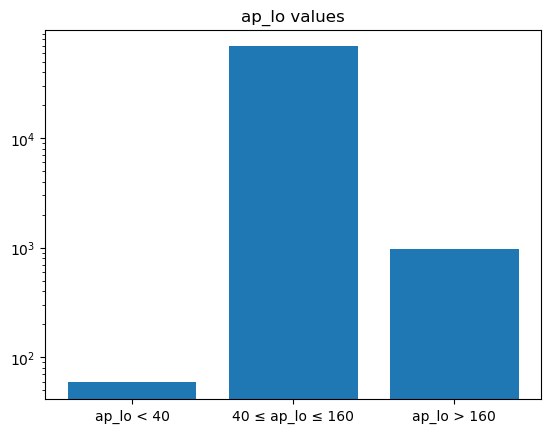

In [81]:
x = ['ap_lo < 40', '40 ≤ ap_lo ≤ 160', 'ap_lo > 160']
y = [sum(df['ap_lo'] < 40), sum((df['ap_lo'] <= 160) & (df['ap_lo'] >= 40)), sum(df['ap_lo'] > 160)]


plt.bar(x, y, log=True, tick_label=x);
plt.title('ap_lo values');

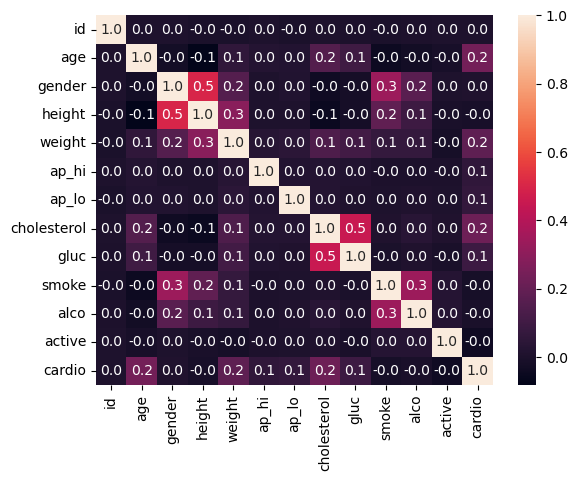

In [82]:
correlation_matrix = df.corr()  # Пирсон

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

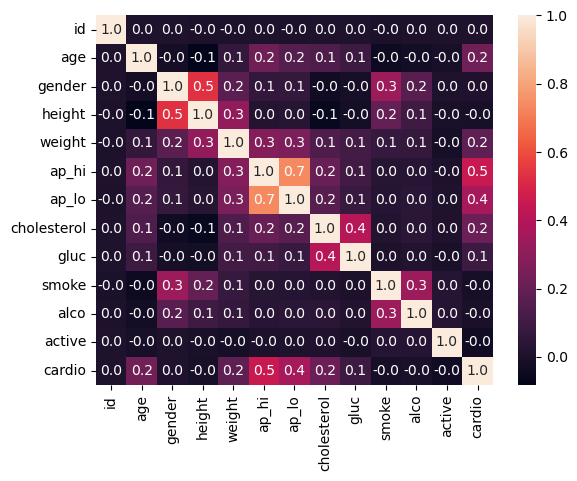

In [83]:
correlation_matrix = df.corr(method='spearman')  # Спирмен

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

На основе матрицы корреляций можно сделать вывод о том, что с таргетной переменной больше всего коррелируют: ap_hi, ap_lo, cholesterol, weight, age. Но признаки ap_hi и ap_lo имеют между собой высокую корреляцию, что плохо с точки зрения внесения новой информации данными в модель. Поэтому можно либо использовать только 1 из этих признаков, либо их среднее, разность и тд.

### vif

Коэффициент инфляции дисперсии или VIF — это мера, которая помогает обнаружить степень мультиколлинеарности в множественной регрессионной модели. Он показывает, насколько увеличивается дисперсия коэффициента оценки из-за линейной зависимости с другими предикторами.  \
VIF для конкретной независимой переменной рассчитывается по формуле: VIF = 1 / (1 – R²), где R² — коэффициент детерминации, полученный путем регрессии этой независимой переменной против всех других независимых переменных в модели.  \
Как правило, значение VIF от 1 до 5 предполагает умеренную корреляцию, которая не может быть проблематичной, тогда как значение VIF выше 5 указывает на значительную мультиколлинеарность, которая может потребовать дальнейшего исследования. Некоторые аналитики используют пороговое значение 10 в качестве эмпирического правила, предполагая, что любая переменная с VIF выше этого значения должна быть тщательно изучена и потенциально удалена из модели, чтобы повысить надежность регрессионного анализа.

In [84]:
features_vif = pd.DataFrame()
features_vif['fearures'] = df.columns

features_vif['vif'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
features_vif

,fearures,vif
0,id,3.978730
1,age,58.118491
2,gender,11.766925
3,height,102.811065
4,weight,31.875107
5,ap_hi,1.704921
6,ap_lo,1.269905
7,cholesterol,6.710880
8,gluc,7.045671
9,smoke,1.366575


признаки height, weight, age имеют очень высокий vif. Поэтому вместо их использования можно посчитать индекс массы тела, возраст разбить на группы.

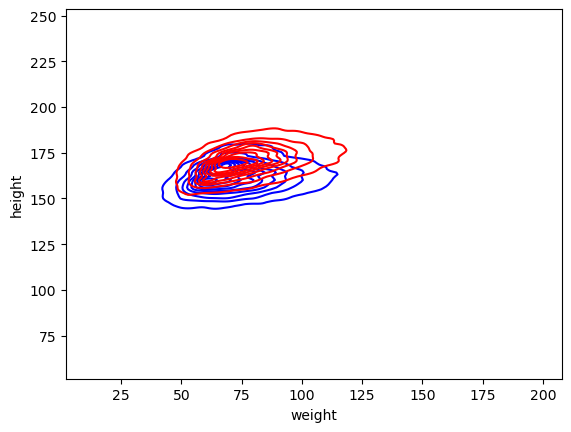

In [85]:
sns.kdeplot(df[df['gender'] == 1][['weight', 'height']], x='weight', y='height', color='blue')
sns.kdeplot(df[df['gender'] == 2][['weight', 'height']], x='weight', y='height', color='red');

будем считать, что gender = 2 - это мужчины. Т.к. у многих объектов рост и вес больше из красного графика в сравнении с синим графиком

## Preprocessing

удалим выбросы в артериальном давлении

In [86]:
mask = (df['ap_hi'] > 220) | (df['ap_hi'] < 60)
if len(df[mask]):
    df = df[~mask]

mask = (df['ap_lo'] > 160) | (df['ap_lo'] < 40)
if len(df[mask]):
    df = df[~mask]

display(df.head())
display(df.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000
mean,49971.272969,19464.278511,1.348731,164.361443,74.119999,126.599593,81.360745,1.364715,1.225976,0.088023,0.053596,0.803374,0.494800
std,28845.542745,2468.174927,0.476572,8.185165,14.330806,16.711728,9.583873,0.679000,0.571959,0.283330,0.225221,0.397450,0.499977
min,0.000000,10798.000000,1.000000,55.000000,11.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24995.500000,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50010.000000,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74864.500000,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,220.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


удалим колонку id

In [87]:
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

display(df.head())
display(df.shape)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


(68755, 12)

### feature engineering

In [88]:
def age_grouping(age):
    if age <= 20:
        return 1
    elif 20 < age <= 40:
        return 2
    else:
        return 3

    


# индекс массы тела
df['bmi'] = np.round(df['weight'] / (df['height'] / 100) ** 2)

# переводим возраст в года
df['age_years'] = df['age'] // 365

display(df.head())
display(df.describe())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22.0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35.0,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24.0,51
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29.0,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.0,47


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years
count,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000,68755.000000
mean,19464.278511,1.348731,164.361443,74.119999,126.599593,81.360745,1.364715,1.225976,0.088023,0.053596,0.803374,0.494800,27.514799,52.827969
std,2468.174927,0.476572,8.185165,14.330806,16.711728,9.583873,0.679000,0.571959,0.283330,0.225221,0.397450,0.499977,6.058060,6.769278
min,10798.000000,1.000000,55.000000,11.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,29.000000
25%,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000,48.000000
50%,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000,53.000000
75%,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000,58.000000
max,23713.000000,2.000000,250.000000,200.000000,220.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,299.000000,64.000000


при bmi > 40 наступает ожирение 3 степени. Иметь bmi > 60 практически невозможно

In [89]:
df[df['bmi']>298]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,299.0,53


In [90]:
df = df[df['bmi'] <= 60]

display(df.head())
display(df.describe())
display(df.shape)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22.0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35.0,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24.0,51
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29.0,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.0,47


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years
count,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000,68696.000000
mean,19464.215486,1.348783,164.409558,74.085739,126.595872,81.359046,1.364854,1.226039,0.088026,0.053584,0.803366,0.494818,27.440972,52.827807
std,2468.029652,0.476589,7.946101,14.223674,16.705018,9.582640,0.679087,0.572002,0.283334,0.225196,0.397456,0.499977,5.224783,6.768853
min,10798.000000,1.000000,100.000000,11.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,29.000000
25%,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.000000,48.000000
50%,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.000000,53.000000
75%,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.000000,58.000000
max,23713.000000,2.000000,250.000000,200.000000,220.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,60.000000,64.000000


(68696, 14)

In [91]:
df['age_groups'] = df['age_years'].apply(age_grouping)

display(df.head())
display(df['age_groups'].value_counts())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years,age_groups
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22.0,50,3
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35.0,55,3
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24.0,51,3
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29.0,48,3
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.0,47,3


age_groups
3    65331
2     3365
Name: count, dtype: int64

In [92]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years,age_groups,pulse_pressure
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,22.0,50,3,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,35.0,55,3,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,24.0,51,3,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,29.0,48,3,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.0,47,3,40


Создадим новый DataFrame с признаками, которые потенциально будут использоваться для обучения модели

In [93]:
data = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'age_years', 'pulse_pressure']]

data.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_years,pulse_pressure
0,2,1,1,0,0,1,0,22.0,50,30
1,1,3,1,0,0,1,1,35.0,55,50
2,1,3,1,0,0,0,1,24.0,51,60
3,2,1,1,0,0,1,1,29.0,48,50
4,1,1,1,0,0,0,0,23.0,47,40


In [94]:
features_vif = pd.DataFrame()
features_vif['fearures'] = data.columns

features_vif['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
features_vif

,fearures,vif
0,gender,9.241013
1,cholesterol,6.743390
2,gluc,6.999965
3,smoke,1.366020
4,alco,1.203058
5,active,4.894619
6,cardio,2.285655
7,bmi,24.872328
8,age_years,34.841903
9,pulse_pressure,16.537168


vif стал меньше, но можно постараться сделать его еще меньше. age_groups не дало снижения мультиколлинеарности.

In [95]:
data = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'pulse_pressure']]

display(data.head())

features_vif = pd.DataFrame()
features_vif['fearures'] = data.columns

features_vif['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
features_vif

,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
0,2,1,1,0,0,1,0,22.0,30
1,1,3,1,0,0,1,1,35.0,50
2,1,3,1,0,0,0,1,24.0,60
3,2,1,1,0,0,1,1,29.0,50
4,1,1,1,0,0,0,0,23.0,40


,fearures,vif
0,gender,8.215997
1,cholesterol,6.683465
2,gluc,6.879612
3,smoke,1.355254
4,alco,1.200799
5,active,4.708316
6,cardio,2.283570
7,bmi,17.754719
8,pulse_pressure,14.793694


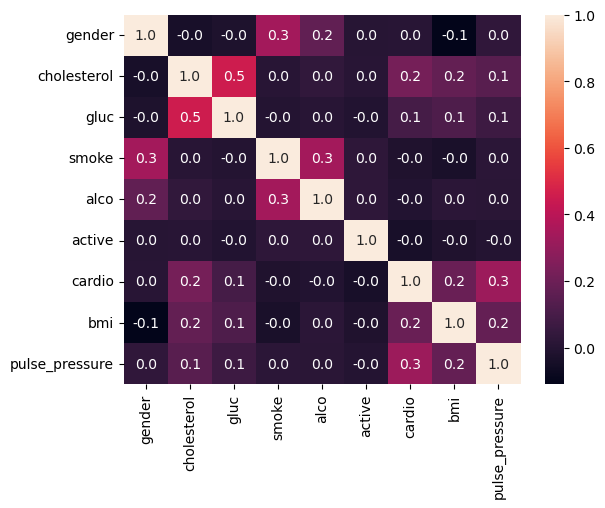

In [96]:
correlation_matrix = data.corr()  # Пирсон

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

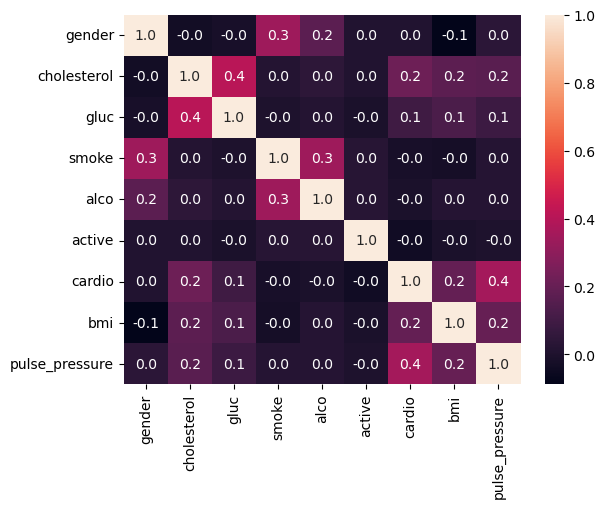

In [97]:
correlation_matrix = data.corr(method='spearman')  # Спирмен

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

хоть и vif все еще большой, но мы значительно снизили его уровень. Чтобы он был в пределах нормы приходится удалить признаки, связанные с индексом массы тела и давлением. Это ключевые признаки в данной задаче , т.к. они имеют наибольшие значения корреляции с таргетом среди признаков. Поэтому мы не можем их удалить.

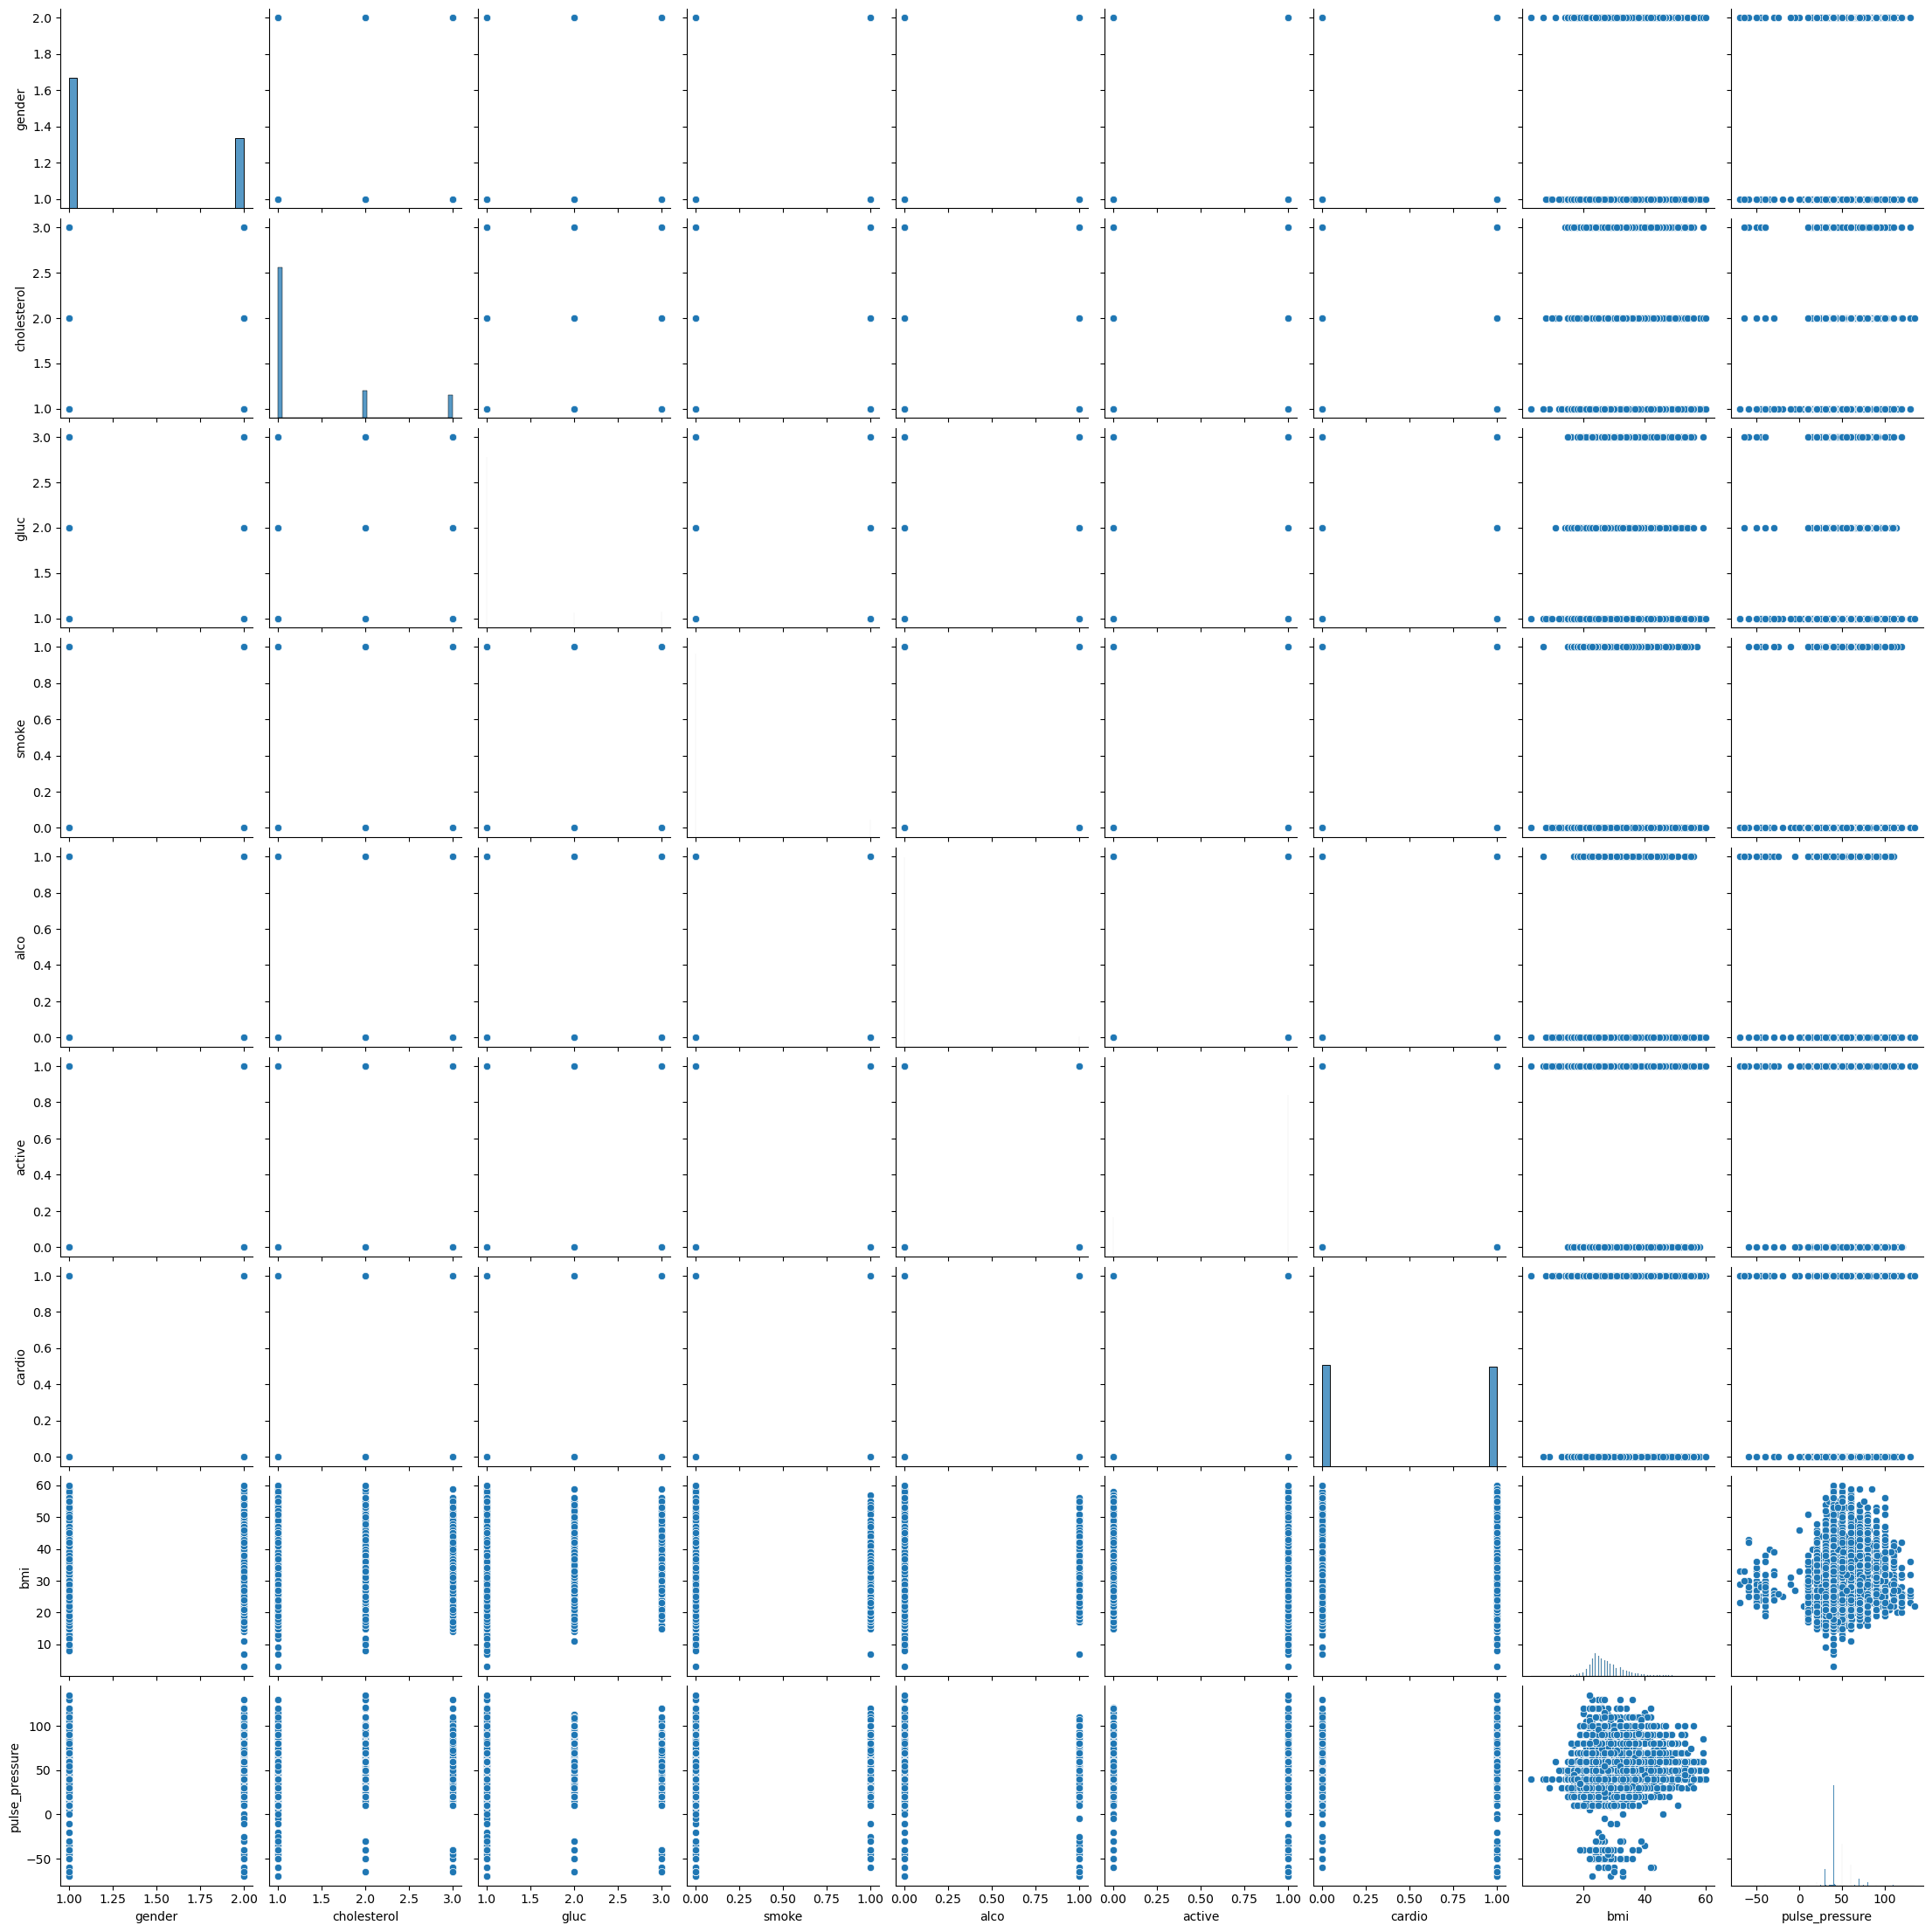

In [98]:
sns.pairplot(data)
plt.show()

In [104]:
if os.path.exists('./dataset/data_cleaning.csv'):
    print('Файл уже существует')
else:
    data.to_csv('./dataset/data_cleaning.csv', index=False)

Файл уже существует
